# 31 · Estimación de trayectoria a partir de flujo óptico

## Campo de flujo óptico y trayectoria aparente

Sea $I(x,y,t)$ la intensidad de imagen y $\mathbf{w}(x,y,t) = (u(x,y,t), v(x,y,t))^\top$ el campo de flujo óptico entre dos instantes consecutivos $t$ y $t+1$. Para un conjunto de puntos de interés $(x_j,y_j)$ se dispone de vectores de desplazamiento

$\Delta x_j^{(k)} = u(x_j,y_j,t_k), \quad \Delta y_j^{(k)} = v(x_j,y_j,t_k)$

en el paso de tiempo $k$. Un desplazamiento medio de la cámara (o del observador) en coordenadas de imagen se puede aproximar mediante un estadístico robusto, por ejemplo la mediana de los desplazamientos de todos los puntos:

$\Delta X^{(k)} = \operatorname{mediana}_j\big(\Delta x_j^{(k)}\big), \quad \Delta Y^{(k)} = \operatorname{mediana}_j\big(\Delta y_j^{(k)}\big)$

La trayectoria acumulada en coordenadas de imagen a lo largo de $K$ pasos se obtiene mediante la suma iterativa

$X^{(k)} = X^{(k-1)} + \Delta X^{(k)}, \quad Y^{(k)} = Y^{(k-1)} + \Delta Y^{(k)}, \quad k = 1,\dots,K$

## Aproximación basada en flujo óptico disperso

Se selecciona un conjunto de puntos de interés en el primer cuadro mediante un detector de esquinas y se siguen estos puntos en el tiempo mediante flujo óptico de Lucas–Kanade piramidal. En cada par de cuadros consecutivos se calcula el desplazamiento de cada punto seguido y se obtiene un desplazamiento medio robusto de la cámara en coordenadas de imagen. La integración de estos desplazamientos proporciona una estimación relativa de la trayectoria.

Imports y ruta del video.

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

VIDEO_PATH = r"C:\\Users\\20808\\Documents\\Repositorios\\Vision_en_Robotica\\imagenes\\sequence3.mp4"

Lectura del primer frame y detección de puntos de interés.

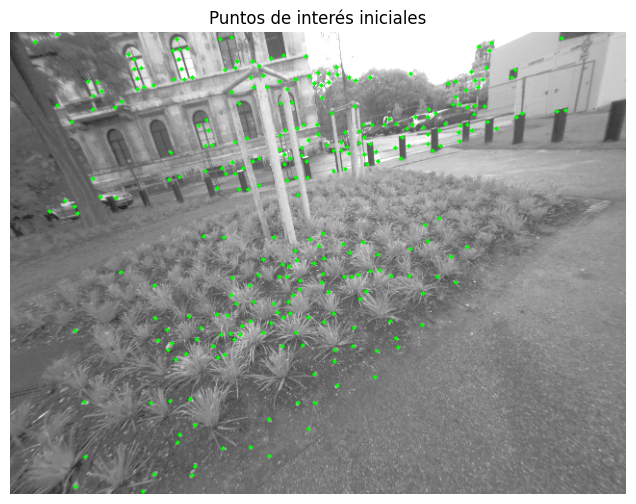

In [22]:
cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame0 = cap.read()
if not ret:
    cap.release()
    raise RuntimeError("No se pudo leer el primer frame del video.")

gray0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)

feature_params = dict(maxCorners=300,
                      qualityLevel=0.01,
                      minDistance=7,
                      blockSize=7,
                      useHarrisDetector=False)

p0 = cv2.goodFeaturesToTrack(gray0, mask=None, **feature_params)

rgb0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB)
vis0 = rgb0.copy()
if p0 is not None:
    for x,y in np.float32(p0).reshape(-1,2):
        cv2.circle(vis0, (int(x),int(y)), 2, (0,255,0), -1)

plt.figure(figsize=(8,6))
plt.imshow(vis0)
plt.title("Puntos de interés iniciales")
plt.axis("off")
plt.show()

Cálculo de flujo óptico disperso y estimación incremental de la trayectoria en coordenadas de imagen.

In [23]:
lk_params = dict(winSize=(21,21),
                 maxLevel=3,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

old_gray = gray0.copy()
old_points = p0

traj_X = [0.0]
traj_Y = [0.0]
frame_indices = [0]

min_points = 20

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if old_points is None or len(old_points) == 0:
        break

    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, gray, old_points, None, **lk_params)
    if p1 is None:
        break

    st = st.reshape(-1)
    good_new = p1[st == 1]
    good_old = old_points[st == 1]

    if good_new.shape[0] < min_points or good_old.shape[0] < min_points:
        break

    good_new = good_new.reshape(-1, 2)
    good_old = good_old.reshape(-1, 2)

    dx = good_new[:,0] - good_old[:,0]
    dy = good_new[:,1] - good_old[:,1]

    dX = np.median(dx)
    dY = np.median(dy)

    traj_X.append(traj_X[-1] + dX)
    traj_Y.append(traj_Y[-1] + dY)
    frame_indices.append(frame_indices[-1] + 1)

    old_gray = gray.copy()
    old_points = good_new.reshape(-1,1,2)

cap.release()

traj_X = np.array(traj_X)
traj_Y = np.array(traj_Y)

Visualización de la trayectoria estimada en coordenadas de imagen.

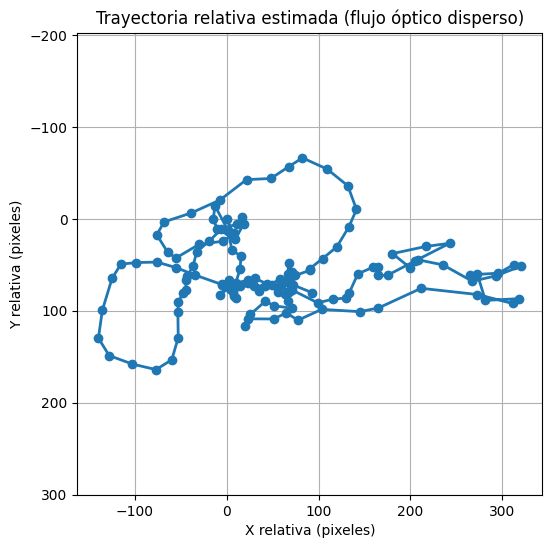

In [24]:
plt.figure(figsize=(6,6))
plt.plot(traj_X, traj_Y, marker='o', linestyle='-', linewidth=2)
plt.xlabel("X relativa (pixeles)")
plt.ylabel("Y relativa (pixeles)")
plt.title("Trayectoria relativa estimada (flujo óptico disperso)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.axis('equal')
plt.show()